# Emotion Classifier

## Instalación de bibliotecas

In [73]:
#%pip install mediapipe
#%pip install imbalanced-learn
#%pip install opencv-python
#!pip install roboflow

## Bibliotecas

In [8]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import pandas as pd
import re
import shutil

### Descarga de nueva base de datos

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key="wIKp4kSiviBkVbZtpPwP")
project = rf.workspace("emotions-dectection").project("human-face-emotions")
version = project.version(30)
dataset = version.download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
df = pd.read_csv('Human-face-emotions-30/train/_annotations.csv')

ruta_imagenes = 'Human-face-emotions-30/train' 
ruta_destino = 'base2'  

for clase in df['class'].unique():
    carpeta_clase = os.path.join(ruta_destino, str(clase))
    os.makedirs(carpeta_clase, exist_ok=True)

for idx, fila in df.iterrows():
    nombre_archivo = fila['filename']
    clase = fila['class']
    
    origen = os.path.join(ruta_imagenes, nombre_archivo)
    destino = os.path.join(ruta_destino, str(clase), nombre_archivo)
    
    if os.path.exists(origen):  
        shutil.copy(origen, destino)
    else:
        print(f"Imagen no encontrada: {origen}")

In [ ]:
# dataset de entrenamiento
train_ds = image_dataset_from_directory(
    'base2',    # ruta donde se va a guardar el dataset
    labels='inferred',  # lee las carpetas como clases
    label_mode='categorical',  # Para one-hot encoding
    batch_size=32,
    image_size=(256, 256),
    color_mode='grayscale',  
    shuffle=True)

class_names = train_ds.class_names

Found 6604 files belonging to 8 classes.


In [12]:
emociones = ["anger", "disgust", "fear", "happy", "sad"]

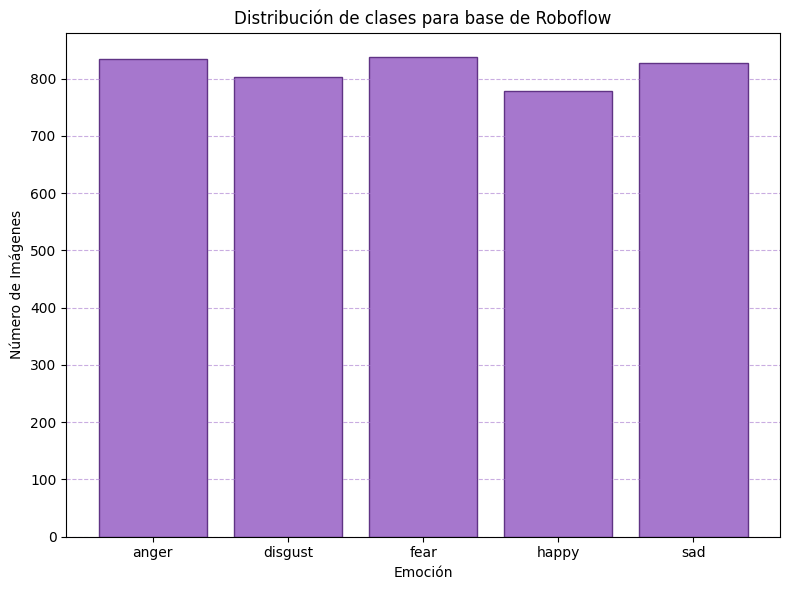

In [ ]:
conteo_emociones = {}
for emocion in emociones:
    carpeta = os.path.join("base2", emocion)
    if os.path.exists(carpeta):
        conteo_emociones[emocion] = len([f for f in os.listdir(carpeta) if f.endswith('.jpg')])
conteo_emociones = dict(sorted(conteo_emociones.items()))
plt.figure(figsize=(8, 6))
plt.bar(conteo_emociones.keys(), conteo_emociones.values(), color='#a677cd', edgecolor='#603385')
plt.title('Distribución de clases para base de Roboflow')
plt.xlabel('Emoción')
plt.ylabel('Número de Imágenes')
plt.grid(axis='y', linestyle='--', alpha=0.6, color="#a677cd")
plt.tight_layout()
plt.show()

In [ ]:
total_imagenes = 0
for emocion in emociones:
    carpeta = os.path.join("base2", emocion)
    if os.path.exists(carpeta):
        num_img = len([f for f in os.listdir(carpeta) if f.endswith('.jpg')])
        print(f"{emocion}: {num_img} imágenes")
        total_imagenes += num_img
    else:
        print(f"{emocion}: carpeta no encontrada")
print(f"\nTotal de imágenes: {total_imagenes}")

anger: 834 imágenes
disgust: 803 imágenes
fear: 838 imágenes
happy: 779 imágenes
sad: 827 imágenes

Total de imágenes: 4081


## Unión de bases de datos

In [ ]:
ruta_ds1 = "dataset/images"  
ruta_ds2 = "base2"            
unidos = "train"            

# crear carpetas destino para cada emocion
for emocion in emociones:
    os.makedirs(os.path.join(unidos, emocion), exist_ok=True)

# procesar dataset 1: carpetas por persona
for persona in os.listdir(ruta_ds1):
    persona_path = os.path.join(ruta_ds1, persona)
    if not os.path.isdir(persona_path):
        continue

    for archivo in os.listdir(persona_path):
        for emocion in emociones:
            # verificar si la emocion esta en el nombre del archivo
            if emocion in archivo.lower():
                origen = os.path.join(persona_path, archivo)
                nuevo_nombre = f"{emocion}_{persona}_{archivo}"
                destino = os.path.join(unidos, emocion, nuevo_nombre)
                shutil.copy(origen, destino)

# procesar dataset 2: carpetas por emocion
for emocion in emociones:
    emocion_path = os.path.join(ruta_ds2, emocion)
    if not os.path.isdir(emocion_path):
        continue

    for i, archivo in enumerate(os.listdir(emocion_path)):
        origen = os.path.join(emocion_path, archivo)
        nuevo_nombre = f"{emocion}_{i}{os.path.splitext(archivo)[1].lower()}"
        destino = os.path.join(unidos, emocion, nuevo_nombre)
        shutil.copy(origen, destino)

# renombrar todos los archivos del dataset final con indices consecutivos
for emocion in emociones:
    carpeta = os.path.join(unidos, emocion)
    if not os.path.isdir(carpeta):
        continue

    archivos = os.listdir(carpeta)
    contador = 0

    for archivo in archivos:
        ext = os.path.splitext(archivo)[1].lower()
        nuevo_nombre = f"{emocion}_{contador}{ext}"
        destino = os.path.join(carpeta, nuevo_nombre)
        origen = os.path.join(carpeta, archivo)

        # si ya existe un archivo con ese nombre, seguir buscando nombre libre
        while os.path.exists(destino):
            contador += 1
            nuevo_nombre = f"{emocion}_{contador}{ext}"
            destino = os.path.join(carpeta, nuevo_nombre)

        if origen != destino:
            os.rename(origen, destino)
        contador += 1

In [13]:
# diccionario para mapear emociones a numeros
MAPEO_EMOCIONES = {
    "sad": 0,
    "happy": 1,
    "disgust": 2,
    "anger": 3,
    "fear": 4
}

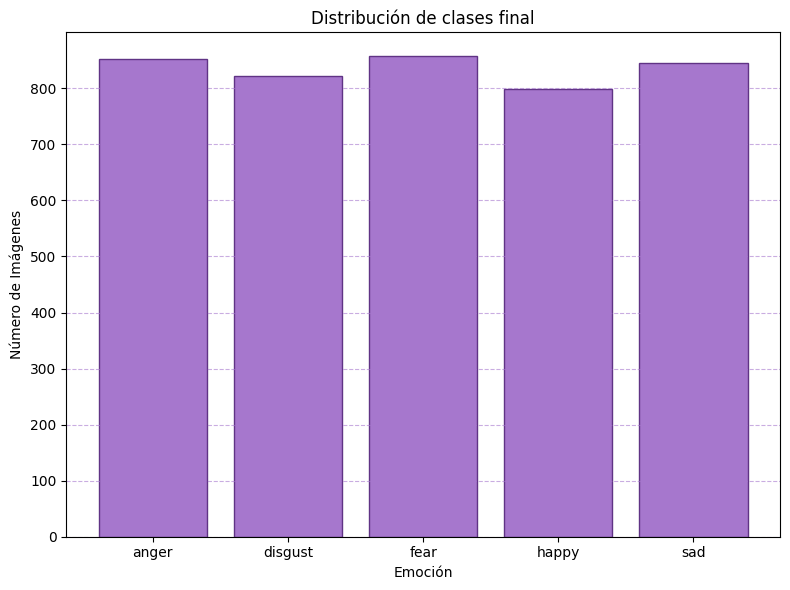

In [52]:
conteo_emociones = {}
for emocion in emociones:
    carpeta = os.path.join(unidos, emocion)
    if os.path.exists(carpeta):
        conteo_emociones[emocion] = len([f for f in os.listdir(carpeta) if f.endswith('.jpg')])
conteo_emociones = dict(sorted(conteo_emociones.items()))
plt.figure(figsize=(8, 6))
plt.bar(conteo_emociones.keys(), conteo_emociones.values(), color='#a677cd', edgecolor='#603385')
plt.title('Distribución de clases final')
plt.xlabel('Emoción')
plt.ylabel('Número de Imágenes')
plt.grid(axis='y', linestyle='--', alpha=0.6, color="#a677cd")
plt.tight_layout()
plt.show()

In [51]:
total_imagenes = 0
for emocion in emociones:
    carpeta = os.path.join("train", emocion)
    if os.path.exists(carpeta):
        num_img = len([f for f in os.listdir(carpeta) if f.endswith('.jpg')])
        print(f"{emocion}: {num_img} imágenes")
        total_imagenes += num_img
    else:
        print(f"{emocion}: carpeta no encontrada")
print(f"\nTotal de imágenes: {total_imagenes}")

anger: 853 imágenes
disgust: 822 imágenes
fear: 857 imágenes
happy: 798 imágenes
sad: 846 imágenes

Total de imágenes: 4176


In [14]:
TAMAÑO_FINAL = 256
RUTA_BASE = "train"

## Funciones de preprocesamiento de imágenes

### Función `cargar_imagen` realiza lo siguiente:
1. Carga una imagen y la convierte en un arreglo de numpy donde cada pixel se representa como un valor numérico (esto si la imagen está en escala de grises) o como un conjuntos de valores si la imagen es a color.

2. Esta imagen se reduce a la mitad de su tamaño original (1/2 resolución) con la función IMREAD_REDUCED_GRAYSCALE_2.


Resultado: Imagen procesada como un arreglo de 2 dimensiones (alto, ancho).

In [15]:
def cargar_imagen(ruta):
    try:
        # IMREAD_REDUCED_GRAYSCALE_2 carga en escala de grises la imagen reducida a su mitad. 
        # Por ejemplo si se carga una imagen de 500x300 el tamaño final seria de 250x150 px.
        imagen = cv2.imread(ruta, cv2.IMREAD_REDUCED_GRAYSCALE_2)
        if imagen is None:
            return None
        return imagen
    except:
        return None

### Función `recortar_imagen` realiza lo siguiente:
1. Recorta la imagen cargada a un cuadrado y luego la redimensiona al TAMAÑO_FINAL (256x256 px)

Resultado: Imagen en 256x256 px

In [16]:
def recortar_imagen(imagen):
    try:
        alto, ancho = imagen.shape[:2] # obtener el alto y ancho de la imagen
        # se toma el lado mas pequeño para recortar un cuadro centrado en la imagen
        lado = min(alto, ancho)
        y = (alto - lado) // 2
        x = (ancho - lado) // 2
        recorte = imagen[y:y+lado, x:x+lado]
        # se redimensiona la imagen recortada al tamaño final deseado 
        return cv2.resize(recorte, (TAMAÑO_FINAL, TAMAÑO_FINAL))
    except:
        return None

### Función `extraer_landmarks` realiza lo siguiente:
1. Recibe una imagen y una instancia del mallador de MediaPipe (FaceMesh), que se encarga de detectar puntos clave del rostro (landmarks).
2. MediaPipe requiere imágenes a color, por lo que también verifica si la imagen es en escala de grises.

La condición `if resultados.multi_face_landmarks` verifica si se detectó al menos un rostro en la imagen, ya que `multi_face_landmarks` es una lista con los resultados de los landmarks de cada cara encontrada, por lo tanto si no se detecta ningún rostro, se regresa un None, pero si se detecta una cara, entonces se toma con `resultados.multi_face_landmarks[0]` (el hecho de que sea índice 0 indica que es el primer rostro detectado).
Luego se accede a `.landmark`, esto es una lista de 468 puntos faciales del modelo Face Mesh, donde cada punto tiene coordenadas `(x, y, z)`, aunque en este caso solo se tomaron las coordenadas `x` e `y` para construir un arreglo de numpy de la forma `(468, 2)`, donde el 468 indica que son 468 puntos faciales y el 2, su número de coordenadas por cada punto. De manera que el arreglo tendría la siguiente forma: [[coordenada x1, coordenada y1],[coordenada x2, coordenada y2], ...]

Resultado: Un arreglo de numpy con las coordenadas normalizadas (x, y) de los puntos clave del rostro o None, si no se detectó ninguna cara.

In [17]:
def extraer_landmarks(imagen, mallador):
    try:
        if len(imagen.shape) == 2: # verificar si la imagen es en escala de grises. Si lo es, entonces se convierte a RGB
            imagen = cv2.cvtColor(imagen, cv2.COLOR_GRAY2RGB) 
        # procesar la imagen con el mallador de MediaPipe
        resultados = mallador.process(imagen)
        ########################################################################################
        if resultados.multi_face_landmarks: 
            return np.array([[p.x, p.y] for p in resultados.multi_face_landmarks[0].landmark])
        ########################################################################################
    except:
        return None
    return None

### Función `normalizar_landmarks`
El objetivo de este paso es transformar los landmarks para que no se vean afectados por el tamaño del rostro y de su posición en la imagen, por lo tanto lo que recibe esta función es un arreglo de landmarks que tiene la forma (478, 2) y donde cada fila es un punto del rostro con coordenadas normalizadas (x, y) entre 0 y 1 (este arreglo fue la salida de MediaPipe que se proceso con la función `extraer_landmarks`).

Por lo tanto, el resultado de aplicar esta función es un vector centrado y escalado de 936 valores que representa la forma del rostro sin importar su posición o tamaño en la imagen que se procese.

In [18]:
def normalizar_landmarks(landmarks):
    try:
        centro = landmarks[1] # landmarks[1] es un punto fijo del rostro por ejemplo la nariz
        landmarks -= centro # se resta el "centro" a los demás puntos de landmarks para centrar la cara
        escala = np.linalg.norm(landmarks[234] - landmarks[454]) # calcula la distancia entre dos puntos fijos del rostro, en este caso, el landmark 234 
        # es la mejilla izquierda y el 454 es la mejilla derecha, esto para obtener el ancho de la cara
        return (landmarks / escala).flatten() # .fltten convierte el arreglo de forma (468, 2) a un arreglo de una dimensión (936,), es decir, un vector de 936 valores
    except:
        return None

## Carga de datos y balanceo de datos

### Función `cargar_dataset`:
-Se carga el modelo de detección landmarks  con: **mp.solutions.face_mesh** 

-Se crea el objeto **mallador**, el cual se utilizará para procesar las imágenes y extraer sus landmarks.

-Se inicializa un diccionario **datos_por_clase** que almacenará los datos obtenidos por cada emoción.

-Luego con **MAPEO_EMOCIONES**, se accede a la carpeta correspondiente con las imágenes por cada emoción.

-Se verifica que la carpeta exista y que contenga imágenes en formato .jpg


* Si hay más de 900 imágenes, solo se usan solo 900 para mantener un balance entre las clases y luego dentro del bucle **for archivo in tqdm ...** se utilizan las funciones previamente desarrolladas para cargar y procesar cada imagen.

* En otro caso, donde haya menos de 800 imágenes, se aplica SMOTE (Synthetic Minority Oversampling Technique) para generar muestras sintéticas hasta llegar a 800 muestras.


In [19]:
def cargar_dataset():
    mp_face_mesh = mp.solutions.face_mesh
    mallador = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3)
# PARAMETROS:
        # static_image_mode=True: indica que se procesarán imágenes, no un video.
        # max_num_faces=1: es el núm. máximo de rostros que buscará el modelo por cada imagen.
        # min_detection_confidence=0.3: solo se detectarán landmarks si el modelo tiene al menos 30% de confianza en que hay un rostro en la imagen.
    datos_por_clase = {}
    emociones = set(MAPEO_EMOCIONES.keys())
    patron_emocion = re.compile(r"^([a-zA-Z]+)")  # extrae letras del inicio del nombre

    for carpeta in sorted(os.listdir(RUTA_BASE)):
        ruta_carpeta = os.path.join(RUTA_BASE, carpeta)
        if not os.path.isdir(ruta_carpeta):
            continue

        archivos = [f for f in os.listdir(ruta_carpeta) if f.lower().endswith('.jpg')]

        for archivo in tqdm(archivos, desc=f"Procesando carpeta {carpeta}"):
            match = patron_emocion.match(archivo)
            if not match:
                continue

            emocion_raw = match.group(1).lower()
            if emocion_raw not in emociones:
                continue  

            codigo = MAPEO_EMOCIONES[emocion_raw]
            ruta = os.path.join(ruta_carpeta, archivo)

            img = cargar_imagen(ruta)
            if img is not None:
                img_proc = recortar_imagen(img)
                if img_proc is not None:
                    landmarks = extraer_landmarks(img_proc, mallador)
                    if landmarks is not None:
                        norm = normalizar_landmarks(landmarks)
                        if norm is not None:
                            if codigo not in datos_por_clase:
                                datos_por_clase[codigo] = ([], [])
                            datos_por_clase[codigo][0].append(norm)
                            datos_por_clase[codigo][1].append(codigo)

    mallador.close()

    X, y = [], []
    for Xc, yc in datos_por_clase.values():
        X.extend(Xc)
        y.extend(yc)

    return np.array(X), np.array(y)


## Entrenar y evaluar el modelo

En este bloque de código se hace lo siguiente: 

-Define un pipeline en el cual se usa **StandardScaler()** para estandarizar los vectores de entrada (restar la media y dividir por la desviación estándar), esto se hace porque el modelo SVM es sensible a la escala de los datos.

-Luego se aplica un clasificador SVM (Máquinas de Vectores de Soporte) con kernel RBF (Radial Basis Function).

-Se configuran los siguientes hiperparámetros:

        C=1: penalización por errores (más grande = más ajuste al entrenamiento (overfitting)).

        gamma='scale': controla la influencia de cada muestra, scale es el valor recomendado por defecto.

        class_weight='balanced': ajusta automáticamente el peso de cada clase con base en su frecuencia.

### Cálculo de la probabilidad
Por defecto, un SVM (SVC) solo genera como salida la clase predicha, no las probabilidades. Sin embargo, al poner probability=True, el modelo:
* Internamente entrena un modelo adicional (una regresión logística) sobre las salidas del SVM para poder estimar la probabilidad de cada clase.
Esto se hace usando una técnica llamada Platt Scaling (es decir, convierte los scores en probabilidades calibradas).
* Por lo tanto, el entrenamieto se vuelve más lento, debido a que entrena el modelo dos veces: una vez para el SVM y otra para calibrar las probabilidades.

Finalmente se entrena el modelo con los datos de X_train, y_train para obtener el modelo que realice las clasificaciones junto con sus probabilidades de pertenecer a determinada emoción y guardarlo en un pkl con **joblib.dump**.

In [ ]:
print("****CARGANDO DATASET****")
X, y = cargar_dataset()
print(f"\nTotal de muestras: {len(X)}\nDistribución final:", Counter(y)) # verificar el balance entre emociones

print("\n****VALIDACIÓN CRUZADA****")
modelo = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', C=1, gamma='scale', class_weight='balanced'))
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
acc_scores = cross_val_score(modelo, X, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(modelo, X, y, cv=cv, scoring='f1_macro')
print(f"Accuracy promedio: {acc_scores.mean():.4f}")
print(f"F1 macro promedio: {f1_scores.mean():.4f}")

print("\n****ENTRENAMIENTO FINAL****")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)
modelo.fit(X_train, y_train)

print("\n****GUARDANDO MODELO****")
joblib.dump(modelo, "modelo_emociones_v3.pkl")

print("\n****EVALUACIÓN****")
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=MAPEO_EMOCIONES.keys()))

****CARGANDO DATASET****


Procesando carpeta sad: 100%|██████████| 846/846 [00:25<00:00, 33.36it/s]



Total de muestras: 4165
Distribución final: Counter({4: 855, 3: 848, 0: 843, 2: 822, 1: 797})

****VALIDACIÓN CRUZADA****
Accuracy promedio: 0.5253
F1 macro promedio: 0.5237

****ENTRENAMIENTO FINAL****

****GUARDANDO MODELO****

****EVALUACIÓN****
              precision    recall  f1-score   support

         sad       0.33      0.40      0.36       169
       happy       0.80      0.72      0.76       159
     disgust       0.49      0.34      0.40       164
       anger       0.41      0.45      0.43       170
        fear       0.54      0.58      0.56       171

    accuracy                           0.50       833
   macro avg       0.51      0.50      0.50       833
weighted avg       0.51      0.50      0.50       833



## Utilizando GridSearchCV

In [ ]:
print("****CARGANDO DATASET****")
X, y = cargar_dataset()
print(f"\ntotal de muestras: {len(X)}\ndistribucion final:", Counter(y))
pipe = make_pipeline(StandardScaler(), SVC(probability=True, class_weight='balanced'))

# definimos el grid de hiperparametros
param_grid = {
    'svc__C': [0.1,0.5, 1, 3,5,10],
    'svc__gamma': ['scale', 'auto', 0.01, 0.001],
    'svc__kernel': ['rbf', 'linear','poly']
}

# validacion cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid search
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X, y)

# mejores resultados
print("\n****MEJORES HIPERPARAMETROS****")
print(grid.best_params_)
print(f"mejor f1_macro: {grid.best_score_:.4f}")

# entrenamiento final con los mejores parametros
print("\n****ENTRENAMIENTO FINAL****")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=21)
modelo_final = grid.best_estimator_
modelo_final.fit(X_train, y_train)

# guardar modelo
print("\n****GUARDANDO MODELO****")
joblib.dump(modelo_final, "model.pkl")

# evaluacion
print("\n****EVALUACION FINAL****")
y_pred = modelo_final.predict(X_test)
print(classification_report(y_test, y_pred, target_names=MAPEO_EMOCIONES.keys()))

****CARGANDO DATASET****


Procesando carpeta sad: 100%|██████████| 846/846 [00:12<00:00, 66.59it/s]



total de muestras: 4165
distribucion final: Counter({4: 855, 3: 848, 0: 843, 2: 822, 1: 797})
Fitting 5 folds for each of 72 candidates, totalling 360 fits

****MEJORES HIPERPARAMETROS****
{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
mejor f1_macro: 0.5968

****ENTRENAMIENTO FINAL****

****GUARDANDO MODELO****

****EVALUACION FINAL****
              precision    recall  f1-score   support

         sad       0.45      0.50      0.47       169
       happy       0.79      0.81      0.80       159
     disgust       0.50      0.46      0.48       164
       anger       0.52      0.48      0.50       170
        fear       0.69      0.70      0.69       171

    accuracy                           0.59       833
   macro avg       0.59      0.59      0.59       833
weighted avg       0.59      0.59      0.59       833



## Visualización

### Función `predecir_emocion`:
-Se carga el modelo previamente entrenado con **joblib.load("modelo_emociones.pkl")**.

-Se genera un diccionario **MAPEO_EMOCIONES_INV**, que invierte las claves y valores de **MAPEO_EMOCIONES** para poder traducir el resultado numérico de la predicción en texto.

* Dentro de la función:

-Se carga la imagen original sin ningún proceso, esta imagen se usa únicamente para mostrarla junto con la predicción.

-Luego, se carga por segunda vez la imagen usando la función **cargar_imagen()** para procesarla.

-Se recorta la imagen usando **recortar_imagen()** para convertirla en un cuadrado.

-Se extraen los landmarks faciales con **extraer_landmarks()**.

* Si la extracción fue exitosa, los landmarks se copian para su visualización, y luego se normalizan con **normalizar_landmarks()** para generar el vector que será usado por el modelo.

-Se realiza la predicción con **modelo.predict([norm_landmarks])**, y se obtiene la etiqueta de la emoción correspondiente a través de **MAPEO_EMOCIONES_INV**.

-Por último, se muestra la predicción con su imagen sin procesar.

In [ ]:
modelo = joblib.load("model.pkl") 
MAPEO_EMOCIONES_INV = {v: k for k, v in MAPEO_EMOCIONES.items()}
mp_face_mesh = mp.solutions.face_mesh
mallador = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.3)

predicciones = []
reales = []

def predecir_emocion(ruta_imagen, emocion_real=None):
    # cargar imagen original sin procesar, es decir, tal cual como se subió
    img_original = cv2.imread(ruta_imagen, cv2.IMREAD_COLOR)
    if img_original is None:
        print("No se pudo cargar la imagen original.")
        return

    # cargar la versión reducida para procesamiento
    img = cargar_imagen(ruta_imagen)  # esta sí puede ser reducida y en gris
    if img is None:
        print("No se pudo cargar la imagen para análisis.")
        return

    img_proc = recortar_imagen(img)
    if img_proc is None:
        print("No se pudo procesar la imagen.")
        return

    landmarks = extraer_landmarks(img_proc,mallador)
    if landmarks is None:
        print("No se detectaron landmarks.")
        return

    landmarks_visuales = landmarks.copy()
    norm_landmarks = normalizar_landmarks(landmarks)
    if norm_landmarks is None:
        print("No se pudo normalizar la imagen.")
        return

    # Predicción y probabilidades
    probs = modelo.predict_proba([norm_landmarks])[0]
    pred_idx = np.argmax(probs)
    pred = modelo.classes_[pred_idx]         # esto devuelve un numero, en este caso el numero asociado con la emocion 
    emocion = MAPEO_EMOCIONES_INV[pred]      # convierte a texto el numero dado
    predicciones.append(emocion)
    reales.append(emocion_real if emocion_real else "desconocida")  # si no se pasa nada, pone 'desconocida'

    print("----------------Predicción:", emocion)


    # imagen con landmarks
    img_color = cv2.cvtColor(img_proc.copy(), cv2.COLOR_GRAY2BGR)
    h, w = img_proc.shape[:2]

    for punto in landmarks_visuales:
        x = int(punto[0] * w)
        y = int(punto[1] * h)
        if 0 <= x < w and 0 <= y < h:
            cv2.circle(img_color, (x, y), 2, (0, 255, 0), -1)

    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_con_landmarks = cv2.cvtColor(img_color.copy(), cv2.COLOR_BGR2RGB)

    # mostrar la imagen sin procesar y la imagen con landmarks
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original_rgb)
    plt.title("Original (sin procesar)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_con_landmarks)
    plt.title(f"Predicción: {emocion}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # probs grafica
    plt.figure(figsize=(8, 4))
    plt.barh(list(MAPEO_EMOCIONES.keys()), probs, color='#a677cd')
    plt.xlabel('Probabilidad')
    plt.title('Probabilidades por emoción')
    plt.xlim(0, 1)
    for i, v in enumerate(probs):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')
    plt.tight_layout()
    plt.show()
    

In [27]:
def graficar_resultados(y_true, y_pred):
    y_true = [y.lower() for y in y_true]
    y_pred = [y.lower() for y in y_pred]

    etiquetas = sorted(list(set(y_true + y_pred)))
    total = len(y_true)
    print(f"Total de muestras evaluadas: {total}\n")
    print("\nMétricas por clase:")
    print(classification_report(y_true, y_pred, labels=etiquetas, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    cm_df = pd.DataFrame(cm, index=etiquetas, columns=etiquetas)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Purples')
    plt.title("Matriz de Confusión (Predicciones individuales)")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()

## test

----------------Predicción: happy


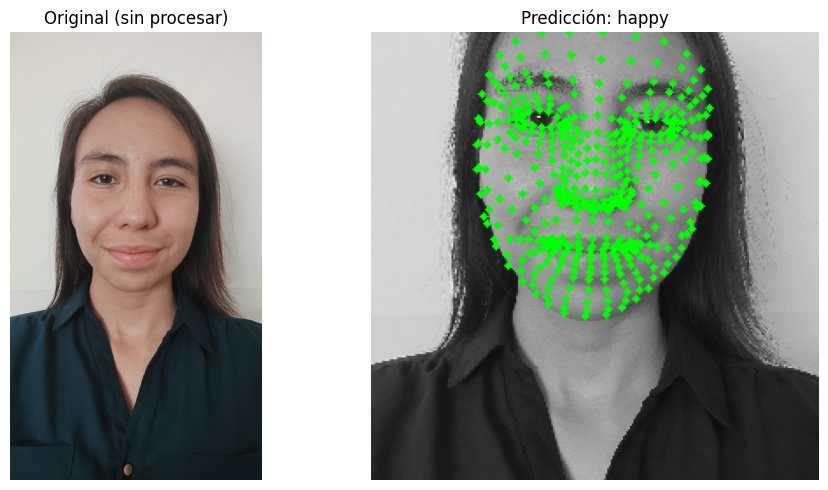

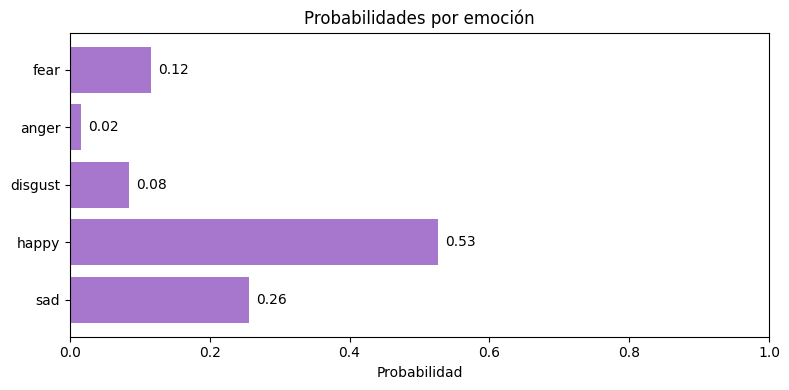

In [23]:
predecir_emocion("test/P3_Felicidad.jpg", emocion_real="Happy")

In [ ]:
predecir_emocion("test/P3_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P3_Disgusto.jpg", emocion_real="Disgust")
predecir_emocion("test/P3_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P3_Miedo.jpg", emocion_real="Fear")
predecir_emocion("test/P3_Tristeza.jpg", emocion_real="Sad")
predecir_emocion("test/P1_Disgusto.jpg", emocion_real="Disgust")
predecir_emocion("test/P1_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P1_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P1_Tristeza.jpg", emocion_real="Sad")
predecir_emocion("test/P2_Disgusto.jpg", emocion_real="Disgust")
predecir_emocion("test/P2_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P2_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P2_Felicidad2.jpg", emocion_real="Happy")
predecir_emocion("test/P2_Miedo.jpg", emocion_real="Fear")
predecir_emocion("test/P2_Tristeza.jpg", emocion_real="Sad")
predecir_emocion("test/P4_Disgusto.jpg", emocion_real="Disgust")
predecir_emocion("test/P4_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P4_Enojo2.jpg", emocion_real="Anger")
predecir_emocion("test/P4_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P4_Miedo.jpg", emocion_real="Fear")
predecir_emocion("test/P4_Tristeza.jpg", emocion_real="Sad")
predecir_emocion("test/P5_Desagrado.jpg", emocion_real="Disgust")
predecir_emocion("test/P5_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P5_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P5_Miedo.jpg", emocion_real="Fear")
predecir_emocion("test/P6_Disgusto.jpg", emocion_real="Disgust")
predecir_emocion("test/P6_Enojo.jpg", emocion_real="Anger")
predecir_emocion("test/P6_Felicidad.jpg", emocion_real="Happy")
predecir_emocion("test/P6_Miedo.jpg", emocion_real="Fear")
predecir_emocion("test/P6_Tristeza.jpg", emocion_real="Sad")

----------------Predicción: happy
----------------Predicción: disgust
----------------Predicción: sad
----------------Predicción: fear
----------------Predicción: sad
----------------Predicción: disgust
----------------Predicción: anger
----------------Predicción: happy
----------------Predicción: anger
----------------Predicción: disgust
----------------Predicción: anger
----------------Predicción: happy
----------------Predicción: happy
----------------Predicción: happy
----------------Predicción: sad
----------------Predicción: sad
----------------Predicción: anger
----------------Predicción: anger
----------------Predicción: happy
----------------Predicción: anger
----------------Predicción: sad
----------------Predicción: disgust
----------------Predicción: anger
----------------Predicción: happy
----------------Predicción: disgust
----------------Predicción: happy
----------------Predicción: sad
----------------Predicción: happy
----------------Predicción: sad
----------------Pre

### Métricas y matriz de confusión 

Total de muestras evaluadas: 30


Métricas por clase:
              precision    recall  f1-score   support

       anger       0.71      0.71      0.71         7
     disgust       0.80      0.67      0.73         6
        fear       1.00      0.20      0.33         5
       happy       0.78      1.00      0.88         7
         sad       0.50      0.80      0.62         5

    accuracy                           0.70        30
   macro avg       0.76      0.68      0.65        30
weighted avg       0.76      0.70      0.67        30



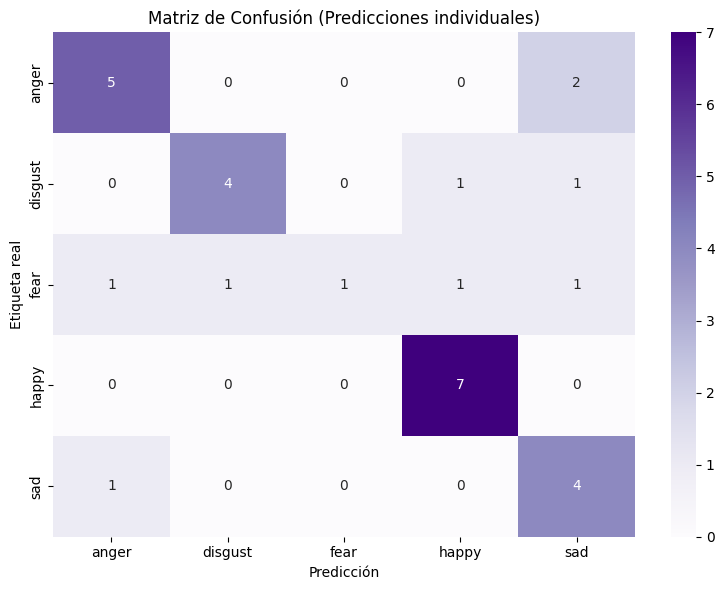

In [29]:
graficar_resultados(reales, predicciones)